# COVID-19 Radiography Database
### COVID-19 Chest X-ray Database

We have the database to ***3616 COVID-19 positive cases*** along with ***10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection)***, and ***1345 Viral Pneumonia images***.

In [1]:
"""
All libraries for EDA.
"""

import os #For file management.
import numpy as np #For basic maths operation.
import pandas as pd #For creating dataframe.
import seaborn as sns #For data visualization
import matplotlib.pyplot as plt #For data visualization
import matplotlib.image as mpimg #For data visualization
from matplotlib.offsetbox import OffsetImage, AnnotationBbox #For data visualization
from glob import glob #For file management.
from PIL import Image #For image visualization
import cv2 #For image visualization
from sklearn.manifold import TSNE
import plotly.express as px

##### Data Import process and basic EDA.

In [2]:
"""
 Creating 'covidData' dataframe with image_id, path, target, class these columns.
 
 ____Variables____
     1. path (str): Path of floder where all images are store.
     2. code_dict (dictionary): Dictionary for assinging code to each disease as COVID:0, Lung_Opacity:1, etc.
     3. title_dict (dictionary): Dictionary for assinging titles to each disease.
     4. imageid_path_dict (dictionary): Dictionary for storing image id with repestitive file path.
     5. covidData (Dataframe): It is final dataframe we get after running this cell.
"""

path = 'COVID-19_Radiography_Dataset/'

code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(code_dict.get) 
covidData['Class'] = covidData['diag'].map(title_dict.get)
covidData.drop(['diag'], axis = 1, inplace = True)

In [3]:
covidData.head()

,image_id,path,target,Class
0,COVID-1,COVID-19_Radiography_Dataset\COVID\COVID-1.png,0,Covid-19
1,COVID-10,COVID-19_Radiography_Dataset\COVID\COVID-10.png,0,Covid-19
2,COVID-100,COVID-19_Radiography_Dataset\COVID\COVID-100.png,0,Covid-19
3,COVID-1000,COVID-19_Radiography_Dataset\COVID\COVID-1000.png,0,Covid-19
4,COVID-1001,COVID-19_Radiography_Dataset\COVID\COVID-1001.png,0,Covid-19


In [4]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


Complementary information on ***Age, Gender or Weight of patients*** samples could be helpful to make the EDA more interesting but we don't have any information regrading to this. Not to mention, that additional information could be extremly important for the Machine Learning model.

## EDA of images

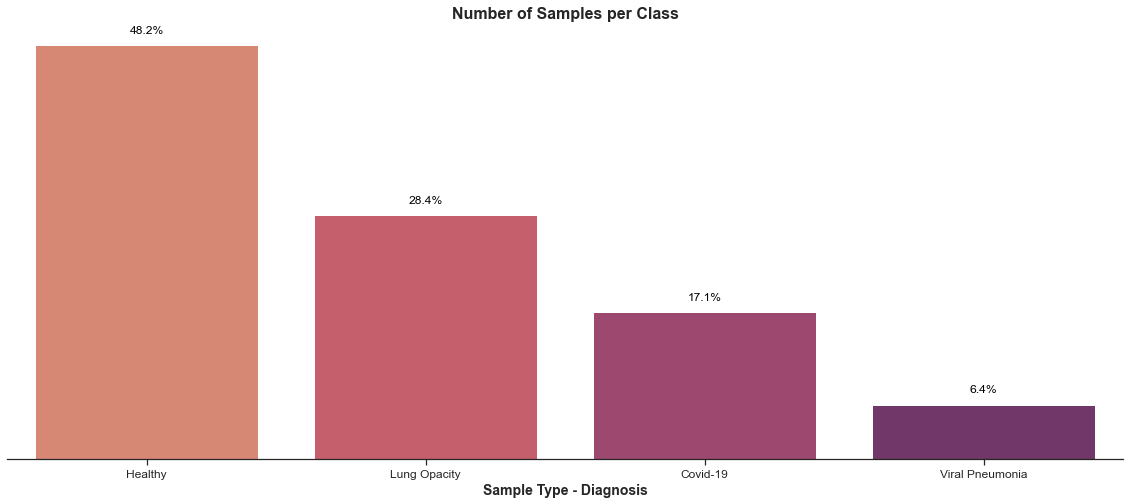

In [5]:
"""
Visualization of dataset to get idea of how much images we have with their respectitive class.

Here we countplot for graph with repectitive lables.
"""
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');

"""
Finding percentage and placing them top of bar.
"""
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

* Healthy and Lung Opacity samples compose 80% of the dataset
* For this application, the main goal is to recognise Covid-19 patients. It will be interesting to see if the model will have greater difficulty in identifying Pneumonia or Covid samples
* Similar to other health conditions prediction problems or unbalanced datasets, it is necessary to prioritise Precision or Recall, since Accuracy can be misleading. The F1-Score is also a reasonable option

In [6]:
"""
Convtering images in numpy array and adding to dataframe.
"""
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

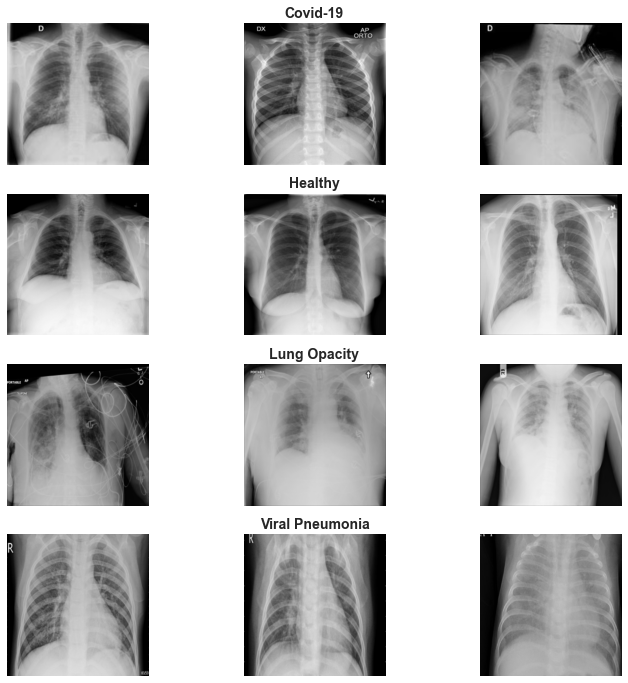

In [7]:
"""
Displaying images of each type.
"""
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,covidData.sort_values(['Class']).groupby('Class')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [8]:
"""
Finding mean, standard deviation, minimum and maximum value of each images, and adding to dataframe for futher analysis.
"""
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

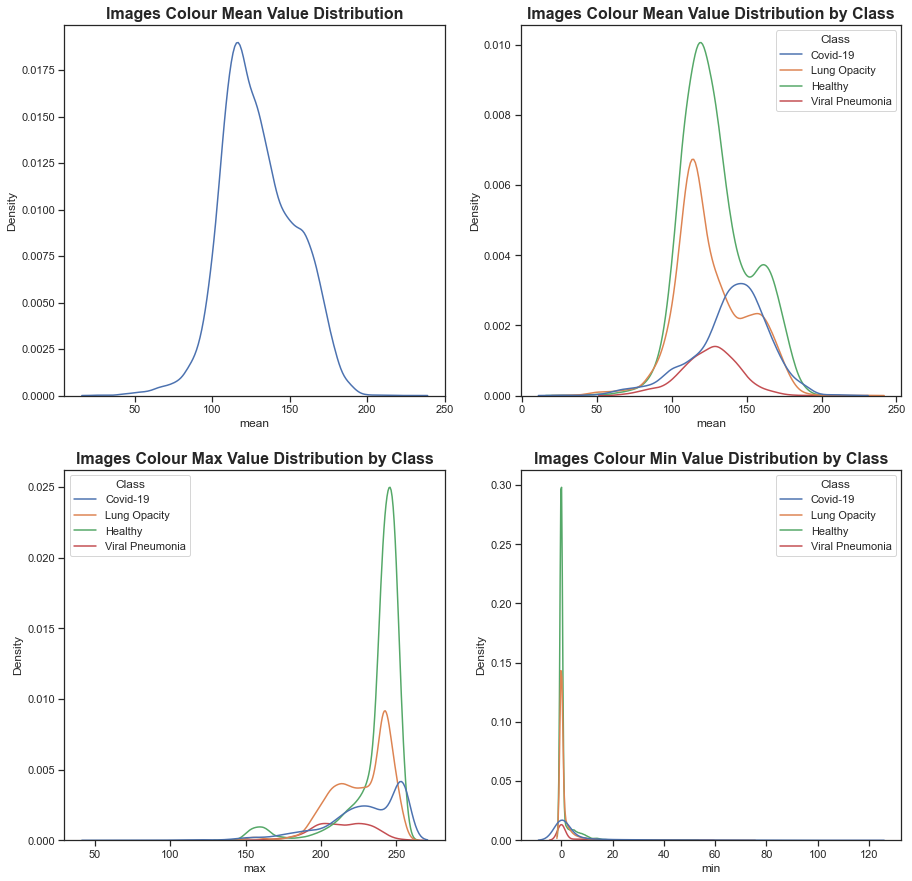

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
dp = sns.kdeplot(data = imageEDA, x = 'mean', ax = ax[0, 0])
ax[0, 0].set_title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold')
dp = sns.kdeplot(data = imageEDA, x = 'mean',  hue = 'Class', ax = ax[0, 1])
ax[0, 1].set_title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold')
dp = sns.kdeplot(data = imageEDA, x = 'max',  hue = 'Class', ax = ax[1, 0])
ax[1, 0].set_title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold')
dp = sns.kdeplot(data = imageEDA, x = 'min', hue = 'Class', ax = ax[1, 1])
ax[1, 1].set_title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold')
plt.show()

* The distribution plot of the whole dataset is very similar to the individual Healthy and Lung Opacity images, due to the number of samples of these two classes
* Separating by class we can visualise that the Mean, Max and Min values vary according to the image class
* Viral Pneumonia is the only class that presents a Normal-like distribution across the three different analysis
* The Max value possible for an image is 255. Most classes peak around this number as expected
Viral Pneumonia is the class that present the most samples with lower Max values if compared to the others. Most samples are within the 200 - 225 range
* Normal (Healthy) and Lung Opacity samples present a very similar distribution of their mean values. Not sure if this could be related to the fact that these classes are the most numerous of the dataset. The different peaks on the distribution could also be because of the image source (e.g. two different hospitals)
* Regarding the Max values, Lung Opacity and Covid-19 present similar distributions (see the "bumps"), while Normal patients have a peak at 150 and then another peak around 250

Text(0.5, 1.0, 'Mean and Standard Deviation of Image Samples')

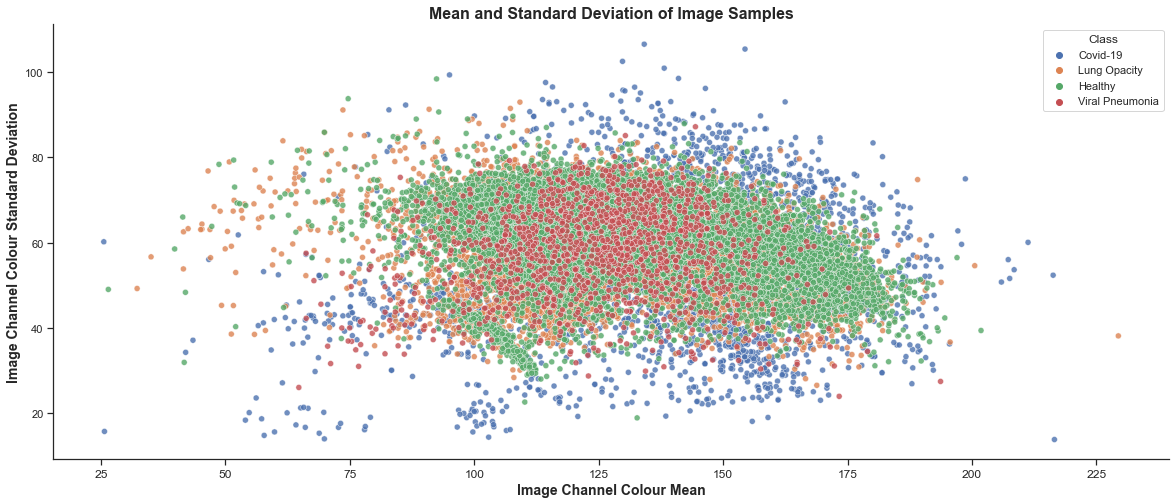

In [10]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold')

* Most images are gathered in the central region of the scatter plot, i.e. there is not much contrast between their pixel values
* Covid-19 samples seem to be the only class to have a small cluster of data on the bottom left side of the plot, where samples with a lower mean and low standard variation lie
* An individual plot by class is required, as the classes are on top of each other and we might miss important details
* We see that all classes have outliers spread around the peripheric area of the graph. It will be interesting to use visualisation to understand how the outliers look like

In [12]:
data_tsne = pd.DataFrame([])

for i in range(0, len(imageEDA)):
    data = pd.DataFrame((imageEDA['image'][i].ravel())).T
    data_tsne = data_tsne.append(data)

In [13]:
data_tsne = data_tsne.iloc[:,:5625]

In [16]:
tsne = TSNE(n_components = 2, perplexity=100, learning_rate=200)

tsne_feature = tsne.fit_transform(data_tsne)

imageEDA['x'] = tsne_feature[: , 0]
imageEDA['y'] = tsne_feature[: , 1]

In [17]:
label = {'x': 'X - axis', 'y': 'Y - axis'}
fig = px.scatter(imageEDA, x='x', y='y',color ='Class',  title = 'TSNE Output')
fig.show()